---

# Section 4: *TxGraffiti*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RandyRDavila/AI-discovery-in-mathematics-with-TxGraffiti/blob/main/notebooks/TxGraffiti_Experiment.ipynb)

In this notebook we walk through the process of implementing *TxGraffiti* on a small graph dataset as shown in Section 4 of the associated manuscript. Click the above Google Colab button to open this notebook. 

To begin, we import necessary dependencies. 

---

In [ ]:
# PuLP will be needed to solve optimization processes below.
!pip install pulp

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme()

from pulp import *
from fractions import Fraction
from itertools import combinations

----

# Build a Sample Dataset
Below we have the edge lists of 9 simple connected graphs. Namely, the 3-vertex path graph $P_3$, the 3-vertex cycle graph $C_3$, the diamond graph, the 4-vertex complete graph $K_4$, the complete bipartite graph $K_{4, 4}$, the star graph $K_{1, 3}$, the double star graph $S(2, 2)$, and the graph obtained by attaching two triangles by a single edge.

----

In [2]:
edge_list_1 = [(0, 1), (1, 2)]
edge_list_2 = [(0, 1), (0, 2), (1, 2)]
edge_list_3 = [(0, 1), (0, 3), (1, 2), (2, 3)]
edge_list_4 = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
edge_list_5 = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
edge_list_6 = [
    (0, 4), (0, 5), (0, 6), (0, 7),
    (1, 4), (1, 5), (1, 6), (1, 7),
    (2, 4), (2, 5), (2, 6), (2, 7),
    (3, 4), (3, 5), (3, 6), (3, 7),
]
edge_list_7 = [(0, 1), (0, 2), (0, 3)]
edge_list_8 = [(0, 1), (0, 2), (0, 3), (3, 4), (3, 5)]
edge_list_9 = [(0, 1), (0, 2), (0, 3), (1, 2), (3, 4), (3, 5), (4, 5)]

dataset = [
    edge_list_1,
    edge_list_2,
    edge_list_3,
    edge_list_4,
    edge_list_5,
    edge_list_6,
    edge_list_7,
    edge_list_8,
    edge_list_9,
]

names = [
    "G_1",
    "G_2",
    "G_3",
    "G_4",
    "G_5",
    "G_6",
    "G_7",
    "G_8",
    "G_9",
]

----

## Choose a Collection of Properties to Compute

In the following code cell we write functions to compute several graph invariants. For simplicity, we choose the following simple numerical invariants:

* The *order* of $G$, denoted $n(G)$ is the number of vertices in $G$.
* The *matching number* of $G$, denoted $\mu(G)$, is the cardinality of a maximum set of edges that do not share endpoints.
* The *independence number* of $G$, denoted $\alpha(G)$, is the cardinality of a maximum set of pairwise nonadjacent vertices.

We will also use the following boolean properities of a graph:
* A graph is *connected* if there exists a path between any two vertices in $G$.
* A graph is a *tree* if it is connected and does not contain a cycle as a subgraph.
* A graph is connected and *regular* if it is connected and every vertex degree is the same.
* A graph is connected and *bipartite* if it is connected and the vertex set can be partitioned into two disjoint independent sets.

To make conjectures involving two or more invariants and also nonlinear conjectures, we also include functions for computing the following:
* The *order* of $G$ minus the *minimum degree*, denoted $n(G) - \delta(G)$ is the number of vertices in $G$ minus its minimum vertex degree.
* The *order* of $G$ minus the *matching number* of $G$, denoted $n(G) - \mu(G)$, is the number of vertices in $G$ minus the cardinality of a maximum set of edges that do not share endpoints.
* The *maximum degree squared*, denoted $\Delta(G)^2$, is the square of the maximum degree of $G$.


----

In [3]:
# The order of the graph - the number of vertices.
def n(G):
    return G.number_of_nodes()

# The matching number of a graph - the cardinality of a maximum set of edges
# which do not share an endpoint.
def matching_number(G):
    prob = LpProblem("MaximumMatchingSet", LpMaximize)
    variables = {edge: LpVariable("x{}".format(i + 1), 0, 1, LpBinary) for i, edge in enumerate(G.edges())}

    # Set the maximum matching objective function
    prob += lpSum(variables)

    # Set constraints
    for node in G.nodes():
        incident_edges = [variables[edge] for edge in variables if node in edge]
        prob += sum(incident_edges) <= 1

    prob.solve()
    solution_set = {edge for edge in variables if variables[edge].value() == 1}
    return len(solution_set)

# The independence number - the cardinality of a maximum set of pairwise nonadjacent
# vertices.
def independence_number(G):
    prob = LpProblem("MaximumIndependentSet", LpMaximize)
    variables = {node: LpVariable("x{}".format(i + 1), 0, 1, LpBinary) for i, node in enumerate(G.nodes())}

    # Set the domination number objective function
    prob += lpSum(variables)

    # Set constraints for independence
    for e in G.edges():
        prob += variables[e[0]] + variables[e[1]] <= 1

    prob.solve()
    solution_set = {node for node in variables if variables[node].value() == 1}
    return len(solution_set)

# The order minus the matching number.
def n_minus_matching_number(G):
    return n(G) - matching_number(G)

# The minimum vertex degree of the graph.
def minimum_degree(G):
    return min(G.degree(node) for node in G.nodes())

# The maximum vertex degree of the graph
def maximum_degree(G):
    return max(G.degree(node) for node in G.nodes())

# The order minus the minimum degree.
def n_minus_minimum_degree(G):
    return n(G) - minimum_degree(G)

# The maximum degree squared.
def maximum_degree_squared(G):
    return maximum_degree(G) ** 2

# Is the graph connected?
def is_connected(G):
    return nx.is_connected(G)

# Is the graph a tree?
def is_tree(G):
    return nx.is_tree(G)

# Is the graph regular?
def is_regular(G):
    return minimum_degree(G) == maximum_degree(G)

# Is the graph bipartite?
def is_bipartite(G):
    return nx.is_bipartite(G)

---

## Create a Tabular Dataset

TxGraffiti produces conjectures one a given tabular dataset like a Pandas DataFrame. So, our next step is to populate a DataFrame with the desired functions applied to the mathematical objects in question - each row being an instance of an object and each column being a function applied to said object.

---

In [4]:
# Create a DataFrame to store the results
rows = []
for i, edge_list in enumerate(dataset):
    G = nx.Graph()
    G.add_edges_from(edge_list)

    row = {
        "name": names[i],
        "n": n(G),
        "matching_number": matching_number(G),
        "independence_number": independence_number(G),
        "n_minus_matching_number": n_minus_matching_number(G),
        "n_minus_minimum_degree": n_minus_minimum_degree(G),
        "maximum_degree_squared": maximum_degree_squared(G),
        "connected": is_connected(G),
        "tree": is_tree(G),
        "connected and regular": is_regular(G),
        "connected and bipartite": is_bipartite(G),
    }
    rows.append(row)

# Convert the list of rows into a pandas DataFrame
df = pd.DataFrame(rows)

# Show the DataFrame
df

,name,n,matching_number,independence_number,n_minus_matching_number,n_minus_minimum_degree,maximum_degree_squared,connected,tree,connected and regular,connected and bipartite
0,G_1,3,1,2,2,2,4,True,True,False,True
1,G_2,3,1,1,2,1,4,True,False,True,False
2,G_3,4,2,2,2,2,4,True,False,True,True
3,G_4,4,2,2,2,2,9,True,False,False,False
4,G_5,4,2,1,2,1,9,True,False,True,False
5,G_6,8,4,4,4,4,16,True,False,True,True
6,G_7,4,1,3,3,3,9,True,True,False,True
7,G_8,6,2,4,4,5,9,True,True,False,True
8,G_9,6,3,2,3,4,9,True,False,False,False


---

## Custome Conjecture Objects
For convience we now write several Python classes as containers for the data stored in conjectures. Note, these are the same classes used by the full graph theory implementation. The primary reason for implementing these classes is to store the hypothesis, conclusion, and object data associated with each found conjecture.

---

In [5]:
 class Hypothesis:
    """
    A class for graph hypotheses.

    Attributes
    ----------
    statement : string
        The statement of the hypothesis.

    Methods
    -------
    __str__():
        Returns the statement of the hypothesis.
    __repr__():
        Returns the statement of the hypothesis.
    __call__(name, df):
        Returns the value of the hypothesis for the graph with the given name in
        the given dataframe.
    """
    def __init__(self, statement):
        self.statement = statement

    def __str__(self):
        return f"{self.statement}"

    def __repr__(self):
        return f"{self.statement}"

    def __call__(self, name, df):
        return df.loc[df["name"] == f"{name}.txt"][self.statement]


class LinearConclusion:
    """
    A class for linear graph conclusions.

    Attributes
    ----------
    lhs : string
        The left-hand side of the conclusion.
    inequality : string
        The inequality of the conclusion.
    slope : float
        The slope of the conclusion.
    rhs : string
        The right-hand side of the conclusion.
    intercept : float
        The intercept of the conclusion.

    Methods
    -------
    __str__():
        Returns the conclusion as a string.
    __repr__():
        Returns the conclusion as a string.
    __eq__(other):
        Returns True if the conclusion is equal to the other conclusion, and
        False otherwise.
    __ne__(other):
        Returns True if the conclusion is not equal to the other conclusion, and
        False otherwise.
    __call__(name, df):
        Returns the value of the conclusion for the graph with the given name in
        the given dataframe.
    """
    def __init__(self, lhs, inequality, slope, rhs, intercept):
        self.lhs = lhs
        self.inequality = inequality
        self.slope = slope
        self.rhs = rhs
        self.intercept = intercept

    def __str__(self):
        if self.slope == 1 and self.intercept == 0.0:
            return f"{self.lhs} {self.inequality} {self.rhs}"
        elif self.slope == 1 and self.intercept != 0.0:
            return f"{self.lhs} {self.inequality} {self.rhs} + {self.intercept}"
        elif self.slope != 1 and self.intercept == 0.0:
            return f"{self.lhs} {self.inequality} {self.slope} {self.rhs}"
        else:
            return f"{self.lhs} {self.inequality} {self.slope} {self.rhs} + {self.intercept}"

    def __repr__(self):
        if self.slope == 1 and self.intercept == 0.0:
            return f"{self.lhs} {self.inequality} {self.rhs}"
        elif self.slope == 1 and self.intercept != 0.0:
            return f"{self.lhs} {self.inequality} {self.rhs} + {self.intercept}"
        elif self.slope != 1 and self.intercept == 0.0:
            return f"{self.lhs} {self.inequality} {self.slope} {self.rhs}"
        else:
            return f"{self.lhs} {self.inequality} {self.slope} {self.rhs} + {self.intercept}"

    def __eq__(self, other):
        if self.lhs != other.lhs:
            return False
        elif self.inequality != other.inequality:
            return False
        elif self.slope != other.slope:
            return False
        elif self.rhs != other.rhs:
            return False
        elif self.intercept != other.intercept:
            return False
        else:
            return True

    def __ne__(self, other):
        return not self.__eq__(other)

    def __call__(self, name, df):
        data = df.loc[df["name"] == f"{name}"]
        if self.inequality == "<=":
            return data[self.lhs] <= self.slope * data[self.rhs] + self.intercept
        else:
            return data[self.lhs] >= self.slope * data[self.rhs] + self.intercept


class LinearConjecture:
    """
    A class for linear graph conjectures.

    Attributes
    ----------
    conclusion : LinearConclusion
        The conclusion of the conjecture.
    hypothesis : Hypothesis
        The hypothesis of the conjecture.
    symbol : string
        The symbol of the conjecture.
    touch : int
        The number of graphs that touch the conjecture, i.e. the number of graphs
        that satisfy the hypothesis and the conclusion with equality.

    Methods
    -------
    __repr__():
        Returns the conjecture as a string.
    __call__(name, df):
        Returns the value of the conjecture for the graph with the given name in
        the given ataframe.
    __eq__(other):
        Returns True if the conjecture is equal to the other conjecture, and
        False otherwise.
    get_sharp_graphs(df):
        Returns the graphs that touch the conjecture.

    Examples
    --------
    >>> from TxGraffiti.classes.conjecture_class import LinearConjecture
    >>> hypothesis = Hypothesis("is_connected")
    >>> conclusion = LinearConclusion("domination_number", "<=", 1/2, "order", 0)
    >>> conjecture = LinearConjecture(conclusion, hypothesis)
    >>> print(conjecture)
    """
    def __init__(self, hypothesis, conclusion, symbol="G", touch=0):
        self.hypothesis = hypothesis
        self.conclusion = conclusion
        self.symbol = symbol
        self.touch = touch

    def __repr__(self):
        hypothesis = f"If {self.symbol} is {self.hypothesis}"
        if self.conclusion.slope == 1 and self.conclusion.intercept == 0.0:
            return f"{hypothesis}, then {self.conclusion.lhs}({self.symbol}) {self.conclusion.inequality} {self.conclusion.rhs}({self.symbol})."
        elif self.conclusion.slope == 1 and self.conclusion.intercept != 0.0:
            return f"{hypothesis}, then {self.conclusion.lhs}({self.symbol}) {self.conclusion.inequality} {self.conclusion.rhs}({self.symbol}) + {self.conclusion.intercept}."
        elif self.conclusion.slope != 1 and self.conclusion.intercept == 0.0:
            return f"{hypothesis}, then {self.conclusion.lhs}({self.symbol}) {self.conclusion.inequality} {self.conclusion.slope} {self.conclusion.rhs}({self.symbol})."
        else:
            return f"{hypothesis}, then {self.conclusion.lhs}({self.symbol}) {self.conclusion.inequality} {self.conclusion.slope} {self.conclusion.rhs}({self.symbol}) + {self.conclusion.intercept}."

    def __call__(self, name, df):
        if self.hypothesis(name, df).values[0]:
            return self.conclusion(name, df).values[0]
        else:
            return False

    def __eq__(self, other):
        return self.hypothesis == other.hypothesis and self.conclusion == other.conclusion and self.symbol == other.symbol

    def get_sharp_graphs(self, df):
        return df.loc[(df[self.hypothesis.statement] == True) & (df[self.conclusion.lhs] == self.conclusion.slope * df[self.conclusion.rhs] + self.conclusion.intercept)]


---

# Generating a Single Inequality

Our first goal will be to formulate a single upper bound inequality for a target invariant in terms of another invariant. To do this, we solve the following linear optimization problem whose feasible solutions form upper bounds on a target invariant.

---

In [6]:
def make_upper_linear_conjecture(
        df,
        target,
        other,
        hyp = "connected",
        symbol = "G",
    ):
    """
    Returns a LinearConjecture object with the given hypothesis, target, and other variables. The
    conclusion is determined by solving a linear program. The inequality is <=.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data.
    target : string
        The name of the target variable.
    other : string
        The name of the other variable.
    hyp : string
        The name of the hypothesis variable.
    symbol : string
        The symbol of the object in the conjecture.

    Returns
    -------
    LinearConjecture
        The conjecture with the given hypothesis, target, and other variables.

    Examples
    --------
    >>> from functions import make_upper_linear_conjecture
    >>> import pandas as pd
    >>> df = pd.read_csv("training-data/data.csv")
    >>> make_upper_linear_conjecture(df, "zero_forcing_number", "independence_number")
    """

    # Extract the data from the dataframe.
    df = df[df[hyp] == True]
    X = df[other].to_numpy()
    Y = df[target].to_numpy()

    # Initialize the LP, say "prob".
    prob = LpProblem("Test_Problem", LpMinimize)

    # Initialize the variables for the LP.
    w = LpVariable("w")
    b = LpVariable("b")

    # Define the objective function.
    prob += np.sum(X*w + b - Y)

    # Define the LP constraints.
    for x, y in zip(X, Y):
        prob += w*x + b - y >= 0

    # Solve the LP.
    prob.solve()

    # Extract the solution.
    m = Fraction(w.varValue).limit_denominator(10)
    b = Fraction(b.varValue).limit_denominator(10)

    # Compute the number of instances of equality - the touch number of the
    # conjecture.
    touch = np.sum(Y == m*X + b)

    # Create the hypothesis and conclusion objects.
    hypothesis = Hypothesis(hyp)
    conclusion = LinearConclusion(target, "<=", m, other, b)

    return LinearConjecture(hypothesis, conclusion, symbol, touch)

def make_lower_linear_conjecture(
        df,
        target,
        other,
        hyp = "connected",
        symbol = "G",
    ):
    """
    Returns a LinearConjecture object with the given hypothesis, target, and other variables. The
    conclusion is determined by solving a linear program. The inequality is >=.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the data.
    target : string
        The name of the target variable.
    other : string
        The name of the other variable.
    hyp : string
        The name of the hypothesis variable.
    symbol : string
        The symbol of the object in the conjecture.

    Returns
    -------
    LinearConjecture
        The conjecture with the given hypothesis, target, and other variables.

    Examples
    --------
    >>> from functions import make_lower_linear_conjecture
    >>> import pandas as pd
    >>> df = pd.read_csv("training-data/data.csv")
    >>> make_lower_linear_conjecture(df, "zero_forcing_number", "independence_number")
    """

    # Extract the data from the dataframe.
    df = df[df[hyp] == True]
    X = df[other].to_numpy()
    Y = df[target].to_numpy()

    # Initialize the LP, say "prob".
    prob = LpProblem("Test_Problem", LpMaximize)

    # Initialize the variables for the LP.
    w = LpVariable("w")
    b = LpVariable("b")

    # Define the objective function.
    prob += np.sum(X*w + b - Y)

    # Define the LP constraints.
    for x, y in zip(X, Y):
        prob += w*x + b - y <= 0

    # Solve the LP.
    prob.solve()

    # Extract the solution.
    m = Fraction(w.varValue).limit_denominator(10)
    b = Fraction(b.varValue).limit_denominator(10)

    # Compute the number of instances of equality - the touch number of the
    # conjecture.
    touch = np.sum(Y == m*X + b)

    # Create the hypothesis and conclusion objects.
    hypothesis = Hypothesis(hyp)
    conclusion = LinearConclusion(target, ">=", m, other, b)

    return LinearConjecture(hypothesis, conclusion, symbol, touch)


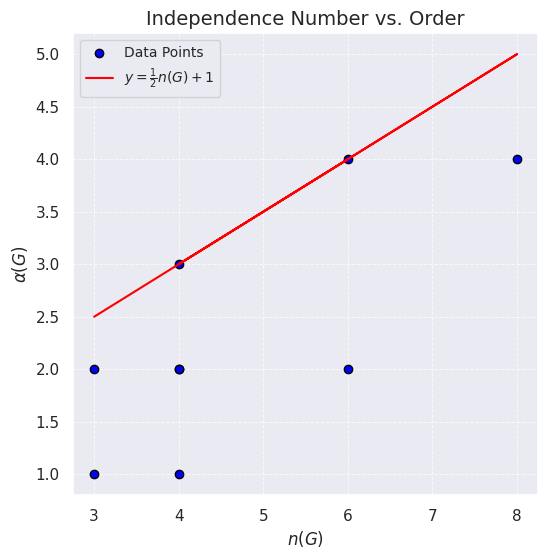

In [7]:
# Example usage. Make a single conjecture on the independence number in terms of
# the order n.
conj = make_upper_linear_conjecture(df, "independence_number", "n", "connected")

# Set figure size.
plt.figure(figsize=(6, 6))

# Scatter plot for the data
plt.scatter(df["n"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")

# Plot the line of best fit based on conjecture's conclusion
plt.plot(
    df["n"],
    conj.conclusion.slope * df["n"] + conj.conclusion.intercept,
    color="red",
    linestyle="-",
    label=r"$y = \frac{1}{2} n(G) + 1$"
)

# Add gridlines
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)

# Labels and title
plt.xlabel(r"$n(G)$", fontsize=12)
plt.ylabel(r"$\alpha(G)$", fontsize=12)
plt.title("Independence Number vs. Order", fontsize=14)

# Add a legend
plt.legend(fontsize=10)

# Save the figure in a high-quality format for manuscript
plt.savefig("independence_number_vs_n_1.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [8]:
# Conjecture an upper bound on the independence number in terms of the order
# for connected and regular graphs.
make_upper_linear_conjecture(df, "independence_number", "n", "connected and regular")

If G is connected and regular, then independence_number(G) <= 1/2 n(G).

In [9]:
# Conjecture an upper bound on the independence number in terms of the order minus
# the minimum degree for connected and regular.
make_upper_linear_conjecture(df, "independence_number", "n_minus_minimum_degree", "connected")

If G is connected, then independence_number(G) <= n_minus_minimum_degree(G).

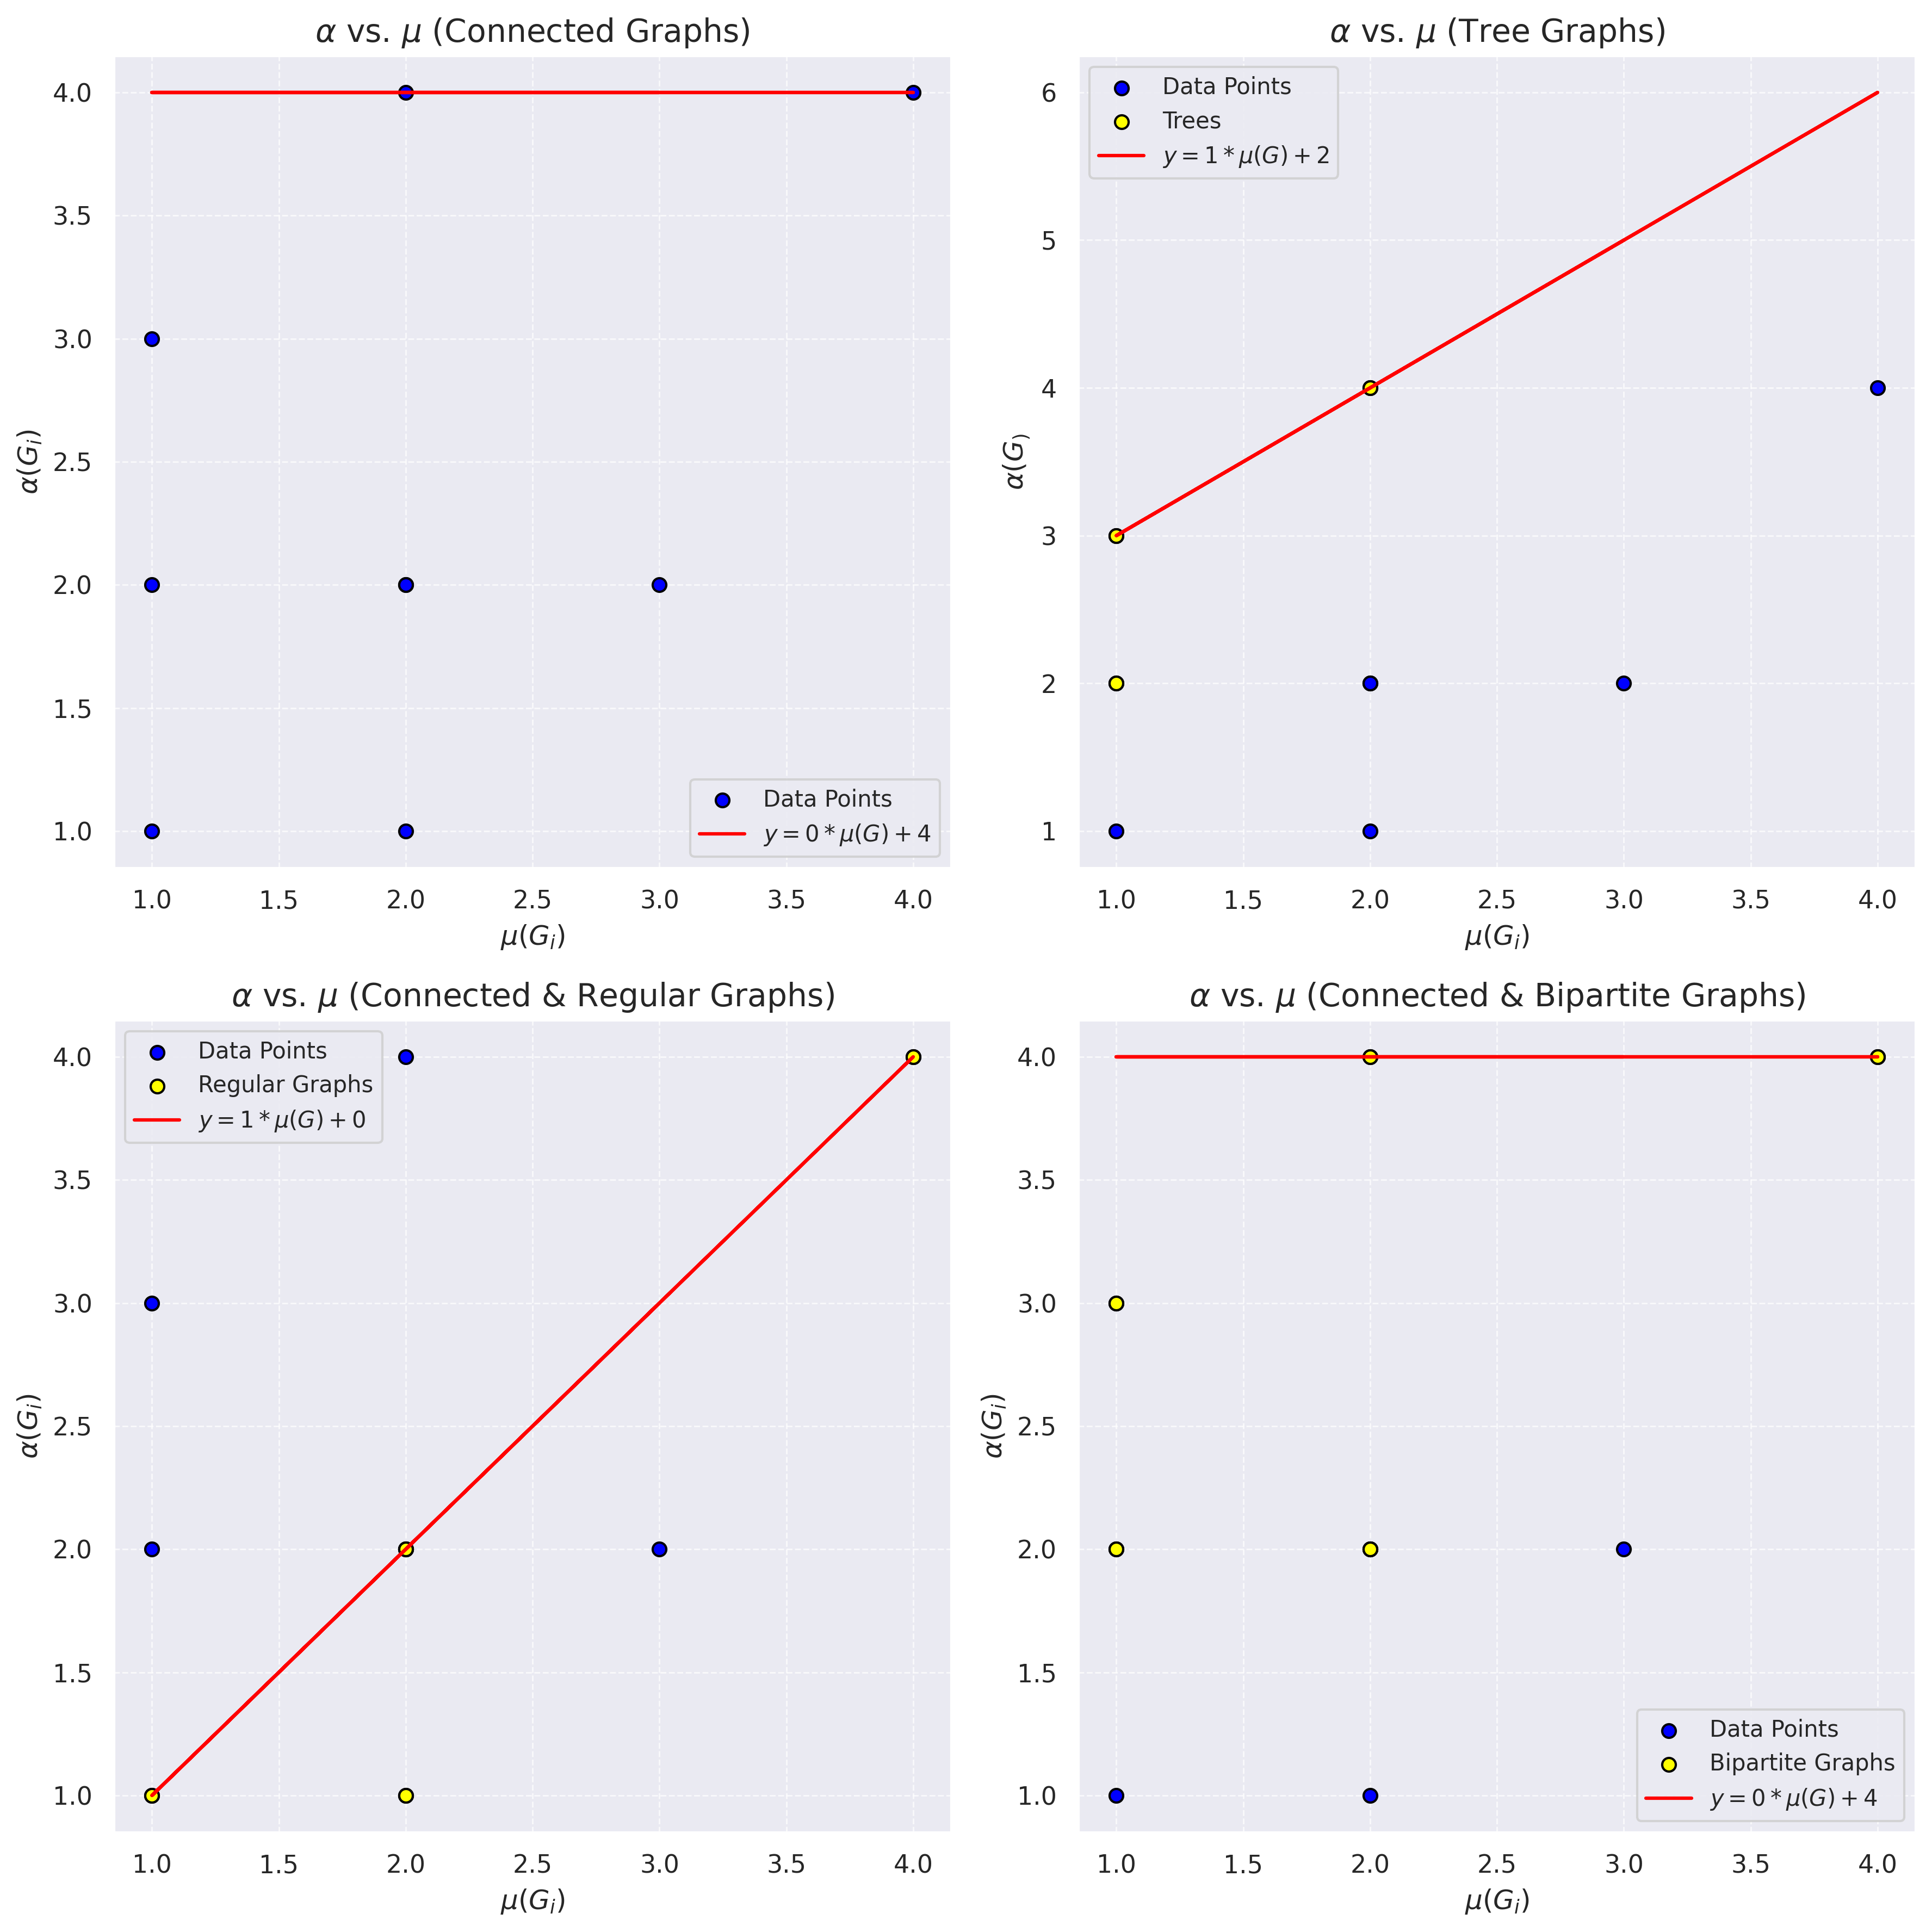

In [10]:
# Example Usage: Formulate the following 4 upper bounds for the independence number.
# The figure produced in this code cell is Figure 2 in the paper
# associated with this notebook.
conj1 = make_upper_linear_conjecture(df, "independence_number", "matching_number", "connected")
conj2 = make_upper_linear_conjecture(df, "independence_number", "matching_number", "tree")
conj3 = make_upper_linear_conjecture(df, "independence_number", "matching_number", "connected and regular")
conj4 = make_upper_linear_conjecture(df, "independence_number", "matching_number", "connected and bipartite")

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=300)

# First subplot: independence number vs n (connected graphs, conj1)
axes[0, 0].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
axes[0, 0].plot(df["matching_number"], conj1.conclusion.slope * df["matching_number"] + conj1.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj1.conclusion.slope}*\mu(G) + {conj1.conclusion.intercept}$")
axes[0, 0].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[0, 0].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[0, 0].set_title(r"$\alpha$ vs. $\mu$ (Connected Graphs)", fontsize=14)
axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0, 0].legend(fontsize=10)

# Second subplot: independence number vs n (trees, conj2)
axes[0, 1].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_trees = df[df["tree"] == True]
axes[0, 1].scatter(df_trees["matching_number"], df_trees["independence_number"], color="yellow", edgecolor="black", label="Trees")
axes[0, 1].plot(df["matching_number"], conj2.conclusion.slope * df["matching_number"] + conj2.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj2.conclusion.slope}*\mu(G) + {conj2.conclusion.intercept}$")
axes[0, 1].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[0, 1].set_ylabel(r"$\alpha(G_)$", fontsize=12)
axes[0, 1].set_title(r"$\alpha$ vs. $\mu$ (Tree Graphs)", fontsize=14)
axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0, 1].legend(fontsize=10)

# Third subplot: independence number vs n (connected and regular graphs, conj3)
axes[1, 0].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_regular = df[df["connected and regular"] == True]
axes[1, 0].scatter(df_regular["matching_number"], df_regular["independence_number"], color="yellow", edgecolor="black", label="Regular Graphs")
axes[1, 0].plot(df["matching_number"], conj3.conclusion.slope * df["matching_number"] + conj3.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj3.conclusion.slope}*\mu(G) + {conj3.conclusion.intercept}$")
axes[1, 0].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[1, 0].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[1, 0].set_title(r"$\alpha$ vs. $\mu$ (Connected & Regular Graphs)", fontsize=14)
axes[1, 0].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1, 0].legend(fontsize=10)

# Fourth subplot: independence number vs n (connected and bipartite graphs, conj4)
axes[1, 1].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_bipartite = df[df["connected and bipartite"] == True]
axes[1, 1].scatter(df_bipartite["matching_number"], df_bipartite["independence_number"], color="yellow", edgecolor="black", label="Bipartite Graphs")
axes[1, 1].plot(df["matching_number"], conj4.conclusion.slope * df["matching_number"] + conj4.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj4.conclusion.slope}*\mu(G) + {conj4.conclusion.intercept}$")
axes[1, 1].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[1, 1].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[1, 1].set_title(r"$\alpha$ vs. $\mu$ (Connected & Bipartite Graphs)", fontsize=14)
axes[1, 1].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1, 1].legend(fontsize=10)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("independence_number_upper_conjectures_grid.png", format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


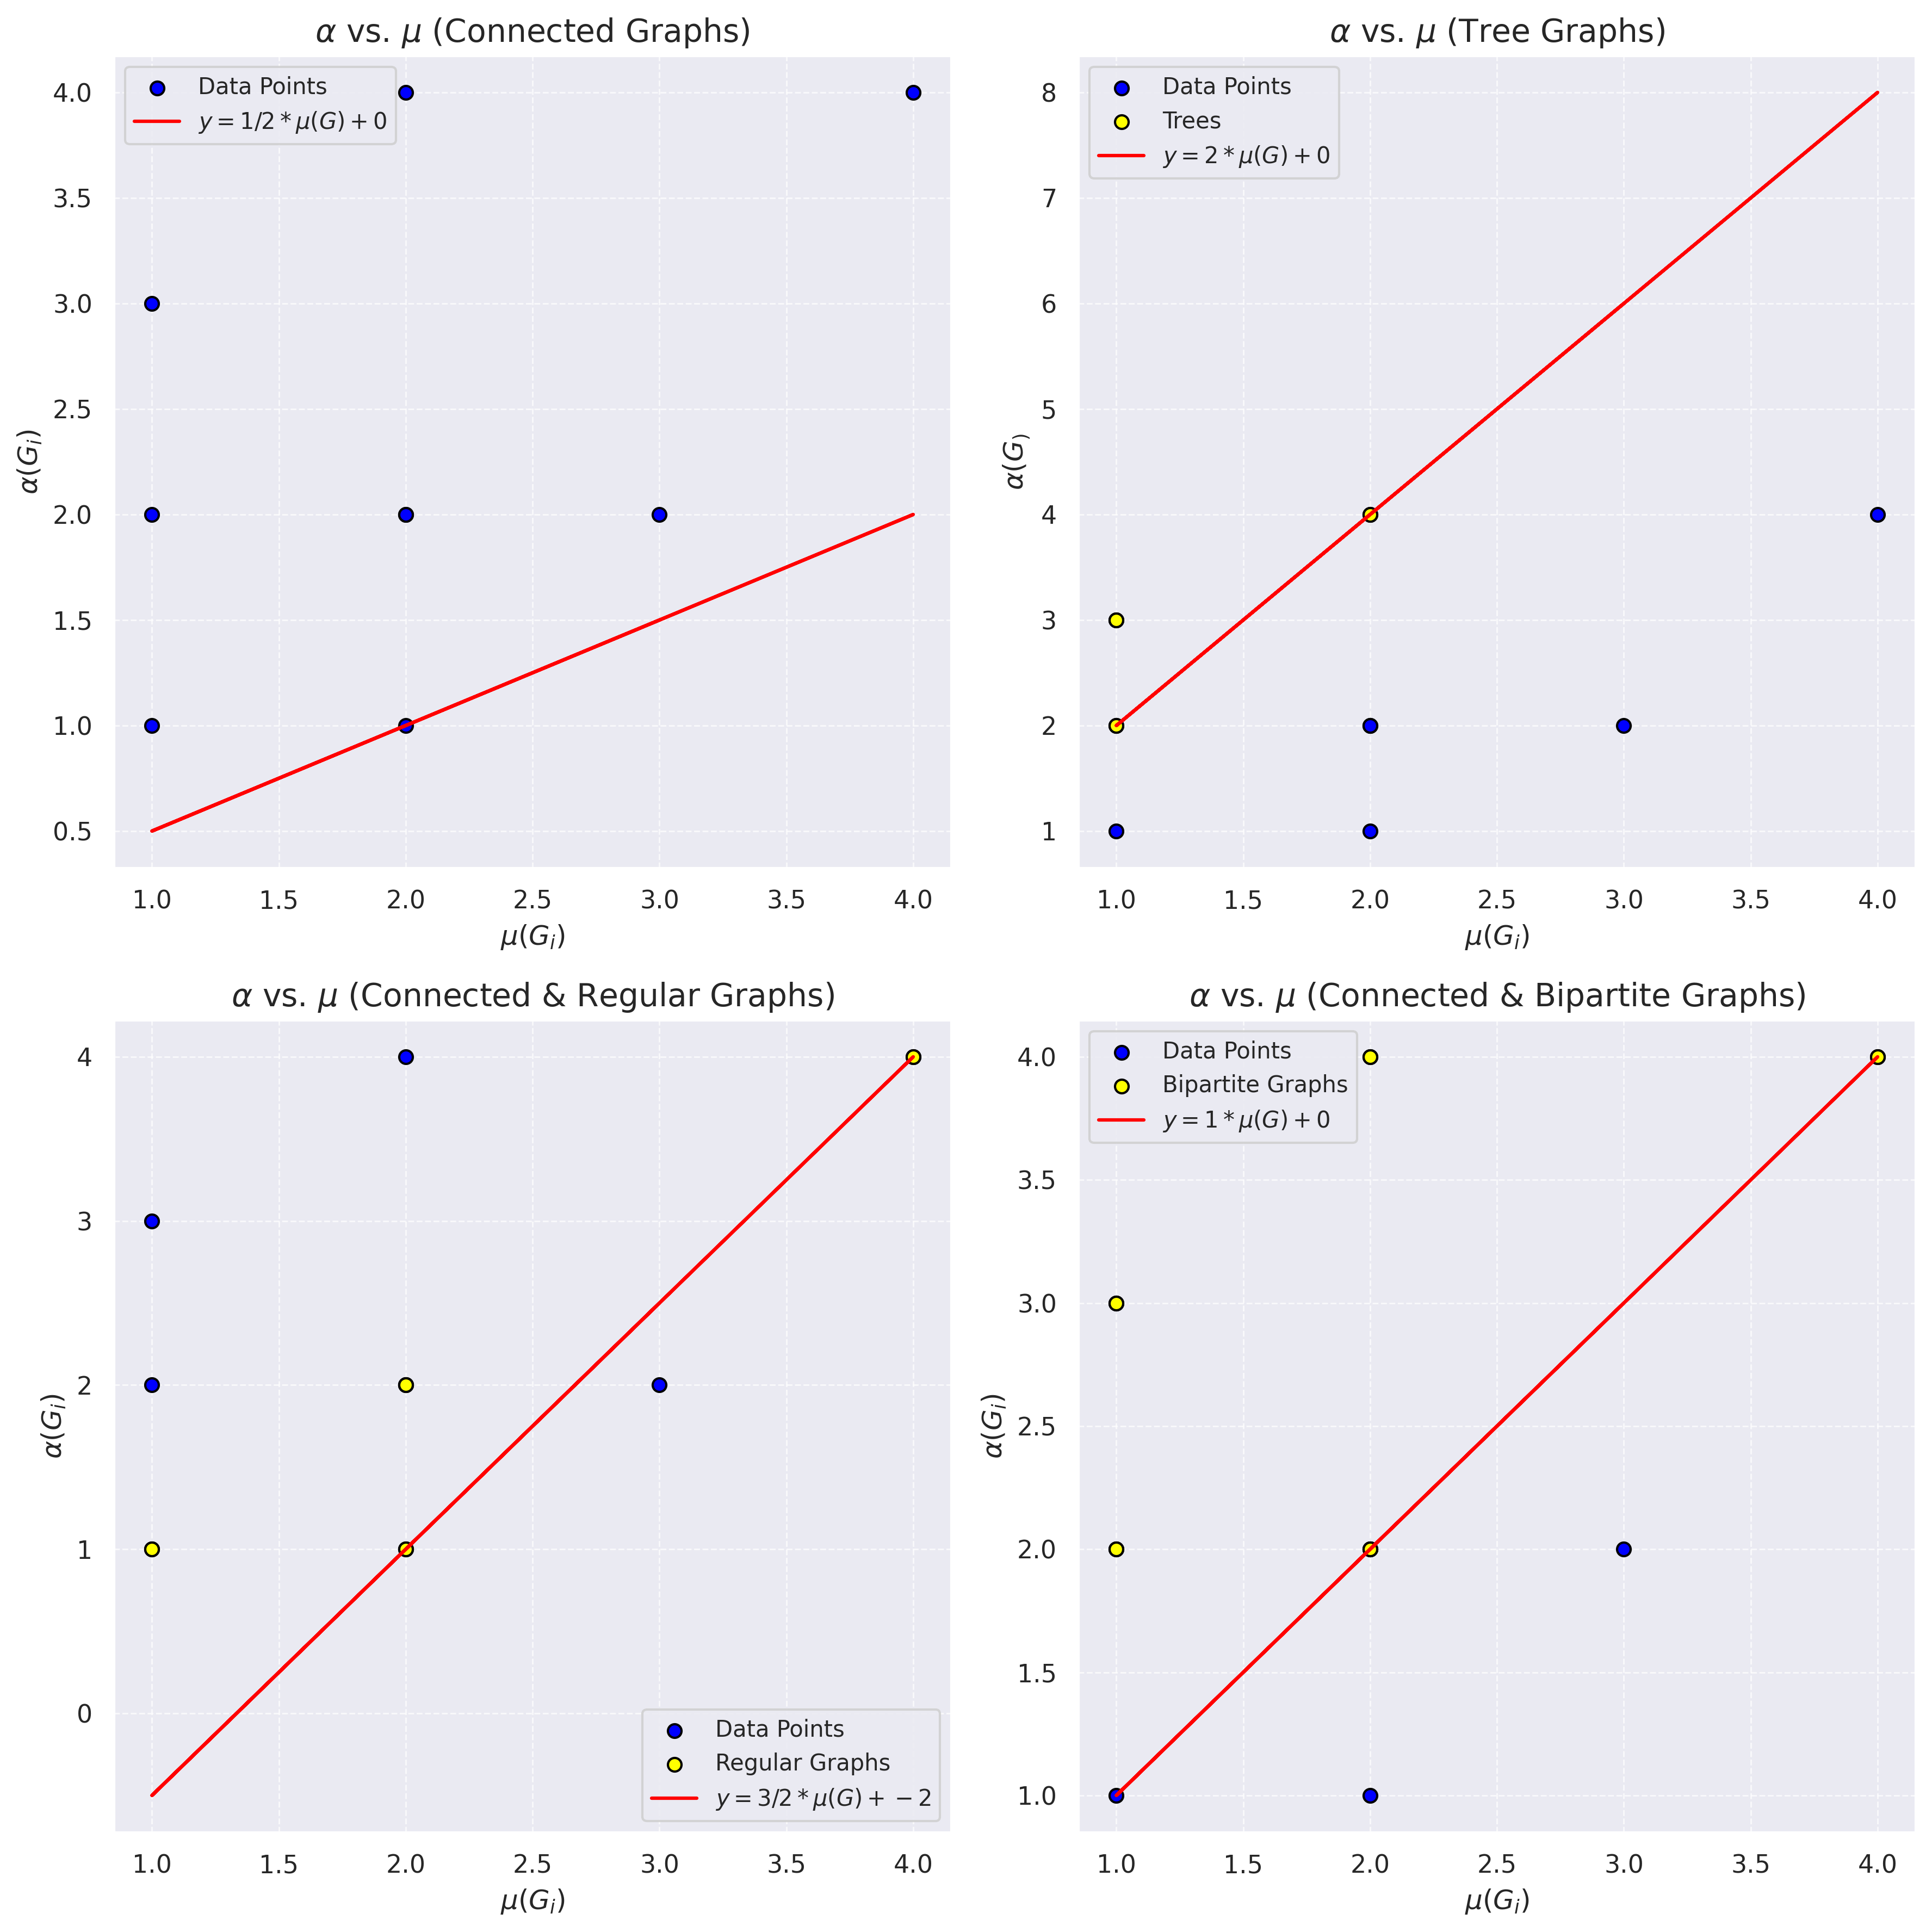

In [11]:
# Formulate the following 4 lower bounds for the independence number.
# The figure produced in this code cell is Figure 2 in the paper
# associated with this notebook.
conj1 = make_lower_linear_conjecture(df, "independence_number", "matching_number", "connected")
conj2 = make_lower_linear_conjecture(df, "independence_number", "matching_number", "tree")
conj3 = make_lower_linear_conjecture(df, "independence_number", "matching_number", "connected and regular")
conj4 = make_lower_linear_conjecture(df, "independence_number", "matching_number", "connected and bipartite")

# Set up a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12), dpi=300)

# First subplot: independence number vs n (connected graphs, conj1)
axes[0, 0].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
axes[0, 0].plot(df["matching_number"], conj1.conclusion.slope * df["matching_number"] + conj1.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj1.conclusion.slope}*\mu(G) + {conj1.conclusion.intercept}$")
axes[0, 0].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[0, 0].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[0, 0].set_title(r"$\alpha$ vs. $\mu$ (Connected Graphs)", fontsize=14)
axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0, 0].legend(fontsize=10)

# Second subplot: independence number vs n (trees, conj2)
axes[0, 1].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_trees = df[df["tree"] == True]
axes[0, 1].scatter(df_trees["matching_number"], df_trees["independence_number"], color="yellow", edgecolor="black", label="Trees")
axes[0, 1].plot(df["matching_number"], conj2.conclusion.slope * df["matching_number"] + conj2.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj2.conclusion.slope}*\mu(G) + {conj2.conclusion.intercept}$")
axes[0, 1].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[0, 1].set_ylabel(r"$\alpha(G_)$", fontsize=12)
axes[0, 1].set_title(r"$\alpha$ vs. $\mu$ (Tree Graphs)", fontsize=14)
axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[0, 1].legend(fontsize=10)

# Third subplot: independence number vs n (connected and regular graphs, conj3)
axes[1, 0].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_regular = df[df["connected and regular"] == True]
axes[1, 0].scatter(df_regular["matching_number"], df_regular["independence_number"], color="yellow", edgecolor="black", label="Regular Graphs")
axes[1, 0].plot(df["matching_number"], conj3.conclusion.slope * df["matching_number"] + conj3.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj3.conclusion.slope}*\mu(G) + {conj3.conclusion.intercept}$")
axes[1, 0].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[1, 0].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[1, 0].set_title(r"$\alpha$ vs. $\mu$ (Connected & Regular Graphs)", fontsize=14)
axes[1, 0].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1, 0].legend(fontsize=10)

# Fourth subplot: independence number vs n (connected and bipartite graphs, conj4)
axes[1, 1].scatter(df["matching_number"], df["independence_number"], color="blue", edgecolor="black", label="Data Points")
df_bipartite = df[df["connected and bipartite"] == True]
axes[1, 1].scatter(df_bipartite["matching_number"], df_bipartite["independence_number"], color="yellow", edgecolor="black", label="Bipartite Graphs")
axes[1, 1].plot(df["matching_number"], conj4.conclusion.slope * df["matching_number"] + conj4.conclusion.intercept, color="red", linestyle="-", label=f"$y = {conj4.conclusion.slope}*\mu(G) + {conj4.conclusion.intercept}$")
axes[1, 1].set_xlabel(r"$\mu(G_i)$", fontsize=12)
axes[1, 1].set_ylabel(r"$\alpha(G_i)$", fontsize=12)
axes[1, 1].set_title(r"$\alpha$ vs. $\mu$ (Connected & Bipartite Graphs)", fontsize=14)
axes[1, 1].grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)
axes[1, 1].legend(fontsize=10)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("independence_number_lower_conjectures_grid.png", format='png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

---

# Generating all Possible Inequalities on a Target Invariant

Now that we can conjecture on a target in terms of a single other invariant, we write a Python function to iterate over multiple invariants and possible boolean properties. This generates a Python list of conjecture objects on a given target invariant.

---

In [12]:
def make_all_upper_linear_conjectures(df, target, others, properties):
    conjectures = [make_upper_linear_conjecture(df, target, other, hyp = prop)
            for other in others for prop in properties if other != target]

    # Remove any conjectures with slope value 0.
    return [conj for conj in conjectures if conj.conclusion.slope != 0]

def make_all_lower_linear_conjectures(df, target, others, properties):
    conjectures = [make_lower_linear_conjecture(df, target, other, hyp = prop)
              for other in others for prop in properties if other != target]

    # Remove any conjectures with slope value 0.
    return [conj for conj in conjectures if conj.conclusion.slope != 0]


---

## Example: Generate all Possible Upper Bounds on the Independence Number $\alpha$

In the following code cell we generate upper bounds for the independence number of connected graphs, trees, connected and regular graphs, and connected and bipartite graphs in terms of the numerical columns in our tabular dataset.

---

In [13]:
target = "independence_number"

invariants = [
    "n",
    "matching_number",
    "independence_number",
    "n_minus_matching_number",
    "n_minus_minimum_degree",
    "maximum_degree_squared",
]
properties = [
    "connected",
    "tree",
    "connected and regular",
    "connected and bipartite"]

# Solve all linear optimization models formulating upper bounds on the target
# invariant.
conjectures = make_all_upper_linear_conjectures(df, target, invariants, properties,)

# Print out the found upper bounds on the target.
print("TxGraffiti Conjectures the Following \n")
for i, conj in enumerate(conjectures):
    print(f"Conjecture {i + 1}. {conj}")
    # Print the number of times the inequality holds with equality, i.e.,
    # the touch number.
    print(f"This bound is sharp on {conj.touch} graphs.")
    print()

TxGraffiti Conjectures the Following 

Conjecture 1. If G is connected, then independence_number(G) <= 1/2 n(G) + 1.
This bound is sharp on 2 graphs.

Conjecture 2. If G is tree, then independence_number(G) <= 1/2 n(G) + 1.
This bound is sharp on 2 graphs.

Conjecture 3. If G is connected and regular, then independence_number(G) <= 1/2 n(G).
This bound is sharp on 2 graphs.

Conjecture 4. If G is connected and bipartite, then independence_number(G) <= 1/2 n(G) + 1.
This bound is sharp on 2 graphs.

Conjecture 5. If G is tree, then independence_number(G) <= matching_number(G) + 2.
This bound is sharp on 2 graphs.

Conjecture 6. If G is connected and regular, then independence_number(G) <= matching_number(G).
This bound is sharp on 3 graphs.

Conjecture 7. If G is connected, then independence_number(G) <= n_minus_matching_number(G).
This bound is sharp on 6 graphs.

Conjecture 8. If G is tree, then independence_number(G) <= n_minus_matching_number(G).
This bound is sharp on 3 graphs.

Co

---

# Static Dalmation Heuristic


---

In [21]:
def static_dalmatian(df, conjectures):
    # Start with the conjecture that has the highest touch number (first in the list).
    conj = conjectures[0]

    # Initialize the list of strong conjectures with the first conjecture.
    strong_conjectures = [conj]

    # Get the set of sharp graphs (i.e., graphs where the conjecture holds as equality) for the first conjecture.
    sharp_graphs = set(conj.get_sharp_graphs(df).index)

    # Iterate over the remaining conjectures in the list.
    for conj in conjectures[1:]:
        # Get the set of sharp graphs for the current conjecture.
        conj_sharp_graphs = set(conj.get_sharp_graphs(df).index)

        # Check if the current conjecture shares the same sharp graphs as any already selected strong conjecture.
        if any(conj_sharp_graphs == set(known.get_sharp_graphs(df).index) for known in strong_conjectures):
            # If it does, add the current conjecture to the list of strong conjectures.
            strong_conjectures.append(conj)

        # Otherwise, check if the current conjecture introduces new sharp graphs (graphs where the conjecture holds).
        elif conj_sharp_graphs - sharp_graphs != set():
            # If new sharp graphs are found, add the conjecture to the list.
            strong_conjectures.append(conj)

            # Update the set of sharp graphs to include the newly discovered sharp graphs.
            sharp_graphs = sharp_graphs.union(conj_sharp_graphs)

    # Return the list of strong, non-redundant conjectures.
    return strong_conjectures


In [15]:
# Solve all possible linear optimization models producing upper bounds on the
# independence number.
conjectures = make_all_upper_linear_conjectures(
    df,
    "independence_number",
    invariants,
    properties,
)

# Sort the conjectures in nonincreasing order by the number of
# instances the inequality holds with equality.
conjectures.sort(key = lambda x: x.touch, reverse=True)

# Apply static-Dalmation.
conjs = static_dalmatian(df, conjectures)
print("TxGraffiti Conjectures the Following \n")
for i, conj in enumerate(conjs):
    print(f"Conjecture {i + 1}. {conj}")
    print(f"This bound is sharp on {conj.touch} graphs.")
    print()

TxGraffiti Conjectures the Following 

Conjecture 1. If G is connected, then independence_number(G) <= n_minus_minimum_degree(G).
This bound is sharp on 7 graphs.

Conjecture 2. If G is connected, then independence_number(G) <= n_minus_matching_number(G).
This bound is sharp on 6 graphs.



In [19]:
# The following function combines all of the conjecturing steps into a single
# simple Python function. This demonstrates that the conjecturing process can be
# expressed as a single algorithm - the WriteOnTheWallAlgorithm.
def write_on_the_wall(df, targets, invariant_names, property_names, use_dalmation=True):
    conjectures = []
    for target in targets:
        # Compute the upper bounds for the target.
        upper_conjectures = make_all_upper_linear_conjectures(df, target, invariant_names, property_names)

        # Compute the lower bounds for the target.
        lower_conjectures = make_all_lower_linear_conjectures(df, target, invariant_names, property_names)

        # Sort both upper and lower bounds by touch number.
        upper_conjectures.sort(key = lambda x: x.touch, reverse=True)
        lower_conjectures.sort(key = lambda x: x.touch, reverse=True)

        # Apply static-Dalmation if requested. Note, this may drastically reduce
        # the number of conjectures presented. Provide use_dalmation=False to not
        # implement this.
        if use_dalmation:
            upper_conjectures = static_dalmatian(df, upper_conjectures)
            lower_conjectures = static_dalmatian(df, lower_conjectures)
        conjectures += upper_conjectures + lower_conjectures

    # Sort the combined conjectures by touch number.
    conjectures.sort(key = lambda x: x.touch, reverse=True)
    return conjectures

In [20]:
# Example usage: Formulate conjectures on both the independence number and matching number.
conjectures = write_on_the_wall(df, ["independence_number", "matching_number"], invariants, properties)


print("TxGraffiti Conjectures the Following \n")
for i, conj in enumerate(conjectures):
    print(f"Conjecture {i + 1}. {conj}")
    print(f"This bound is sharp on {conj.touch} graphs.")
    print()

TxGraffiti Conjectures the Following 

Conjecture 1. If G is connected, then independence_number(G) <= n_minus_minimum_degree(G).
This bound is sharp on 7 graphs.

Conjecture 2. If G is connected, then independence_number(G) <= n_minus_matching_number(G).
This bound is sharp on 6 graphs.

Conjecture 3. If G is connected and bipartite, then independence_number(G) >= n_minus_matching_number(G).
This bound is sharp on 5 graphs.

Conjecture 4. If G is connected, then matching_number(G) <= 1/2 n(G).
This bound is sharp on 5 graphs.

Conjecture 5. If G is connected, then matching_number(G) <= n_minus_matching_number(G).
This bound is sharp on 5 graphs.

Conjecture 6. If G is connected and regular, then independence_number(G) >= n_minus_minimum_degree(G).
This bound is sharp on 4 graphs.

Conjecture 7. If G is connected, then independence_number(G) >= n_minus_matching_number(G) + -1.
This bound is sharp on 3 graphs.

Conjecture 8. If G is connected, then independence_number(G) >= 1/3 n_minus_

In [19]:
# A function for updating the dataframe.
def update_data(df, new_graph, name):
    df = df.copy()
    # Define the new row to append
    new_row = {
        "name": name,
        "n": n(new_graph),
        "matching_number": matching_number(new_graph),
        "independence_number": independence_number(new_graph),
        "n_minus_matching_number": n_minus_matching_number(new_graph),
        "n_minus_minimum_degree": n_minus_minimum_degree(new_graph),
        "maximum_degree_squared": maximum_degree_squared(new_graph),
        "connected": is_connected(new_graph),
        "tree": is_tree(new_graph),
        "bipartite": is_bipartite(new_graph),
        "regular": is_regular(new_graph),
    }

    # Convert the new row to a DataFrame
    new_row_df = pd.DataFrame([new_row])

    # Append the new row to the existing DataFrame using pd.concat()
    df = pd.concat([df, new_row_df], ignore_index=True)

    return df

In [20]:
# Example usage. Add the Petersen graph and recompute the conjectures.

df = update_data(df, nx.petersen_graph(), "Petersen")
conjectures = write_on_the_wall(df, ["independence_number", "matching_number"], invariants, properties)

for i, conj in enumerate(conjectures):
    print(f"Conjecture {i + 1}. {conj}")
    print(f"This bound is sharp on {conj.touch} graphs.")
    print()

Conjecture 1. If G is connected, then matching_number(G) <= 1/2 n(G).
This bound is sharp on 6 graphs.

Conjecture 2. If G is connected, then matching_number(G) <= n_minus_matching_number(G).
This bound is sharp on 6 graphs.

Conjecture 3. If G is connected and regular, then matching_number(G) >= independence_number(G).
This bound is sharp on 3 graphs.

Conjecture 4. If G is connected and regular, then matching_number(G) >= n_minus_minimum_degree(G).
This bound is sharp on 3 graphs.

Conjecture 5. If G is tree, then matching_number(G) <= 1/3 n(G).
This bound is sharp on 2 graphs.

Conjecture 6. If G is tree, then matching_number(G) <= 1/2 independence_number(G).
This bound is sharp on 2 graphs.

Conjecture 7. If G is tree, then matching_number(G) <= 1/2 n_minus_matching_number(G).
This bound is sharp on 2 graphs.

Conjecture 8. If G is tree, then matching_number(G) <= 1/3 n_minus_minimum_degree(G) + 1/3.
This bound is sharp on 2 graphs.

Conjecture 9. If G is tree, then matching_number